In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import linalg as LA
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
from src import SmoothSailing, kappa, NeuralNet

In [2]:
args = SimpleNamespace(batch_size=32, test_batch_size=1000, epochs=50,
                       lr=0.0001, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

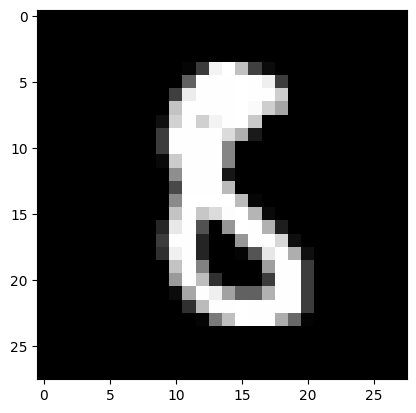

In [4]:
data, train_labels = next(iter(train_loader))
show_img = data[1][0].numpy()
input_dim = data[1].shape[1] * data[1].shape[2]
plt.imshow(show_img, cmap='gray')
plt.show()

In [61]:
snr = []
for i in range(31):
    show_img = data[i][0].numpy()
    snr.append(np.linalg.norm(show_img) / np.linalg.norm(0.1*np.random.randn(show_img.shape[0],show_img.shape[1])))
snr = np.array(snr)
np.mean(snr)

9.446298503056322

In [8]:
torch.manual_seed(args.seed)
model = NeuralNet().to(device)
sail = SmoothSailing(beta=10)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

torch.manual_seed(args.seed)
model_reg = NeuralNet().to(device)
smoothsail = SmoothSailing(beta=100)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=args.lr)
#optim.SGD(model_reg.parameters(), lr=args.lr, momentum=args.momentum)

In [10]:
fit = []
fit_val = []
fit_reg = []
fit_reg_val = []
acc = []
acc_reg = []
cond = []
cond_reg = []

W = model.linear1.weight.data
cond.append(kappa(W))

W_reg = model_reg.linear1.weight.data
cond_reg.append(kappa(W_reg))

print(f"Init condition numbers:")
print(f"\tBaseline condition number {cond[-1]:.2f}")
print(f"\tReguarized condition number {cond_reg[-1]:.2f}")

# train and evaluate

for epoch in range(args.epochs):
    running_loss = 0.0
    running_loss_reg = 0.0

    running_val_loss = 0.0
    running_val_loss_reg = 0.0

    model.train()
    model_reg.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, input_dim))
        data, target = data.to(device), target.to(device)

        output = model(data)
        W = model.linear1.weight
        loss, loss_regu = sail(output, target, W)
        optimizer.zero_grad()
        loss_regu.backward()
        optimizer.step()

        output_reg = model_reg(data)
        W = model_reg.linear1.weight
        loss_bas, loss_reg = smoothsail(output_reg, target, W)
        optimizer_reg.zero_grad()
        loss_reg.backward()
        optimizer_reg.step()

        running_loss += loss.item()
        running_loss_reg += loss_bas.item()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss_reg: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss_bas.item()))


    model.eval()
    model_reg.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data = Variable(data.view(-1, input_dim))
            data, target = data.to(device), target.to(device)

            output = model(data)

            W = model.linear1.weight
            loss, loss_regu = sail(output, target, W)
            

            output_reg = model_reg(data)
            W = model_reg.linear1.weight
            loss_bas, loss_reg = smoothsail(output_reg, target, W)

            running_val_loss += loss.item()
            running_val_loss_reg += loss_bas.item()

            pred = output.max(1, keepdim=True)[1]
            pred_reg = output_reg.max(1, keepdim=True)[1]
            accur = pred.eq(target.view_as(pred)).sum().item()
            accur_reg = pred_reg.eq(target.view_as(pred_reg)).sum().item()


    W = model.linear1.weight.data
    cond.append(kappa(W))
    W_reg = model_reg.linear1.weight.data
    cond_reg.append(kappa(W_reg))

    fit.append(running_loss/len(test_loader.dataset))
    fit_val.append(running_val_loss/args.test_batch_size)
    fit_reg.append(running_loss_reg/len(test_loader.dataset))
    fit_reg_val.append(running_val_loss_reg/args.test_batch_size)

    acc.append(accur/args.test_batch_size*100)
    acc_reg.append(accur_reg/args.test_batch_size*100)


    print(f"Epoch {epoch+1}/{args.epochs}:")
    print(f"\tLoss: {fit[-1]:.2f} with condition number {cond[-1]:.2f}")
    print(f"\tRegularized Loss: {fit_reg[-1]:.2f} with condition number {cond_reg[-1]:.2f}")
    print(f"\tAccuracy: {acc[-1]:.2f}%")
    print(f"\tRegularized Accuracy: {acc_reg[-1]:.2f}%")


torch.save(model.state_dict(), "model_10_class_tik.pt")
torch.save(model_reg.state_dict(), "model_100_class_tik.pt")

Init condition numbers:
	Baseline condition number 5241.86
	Reguarized condition number 4013.72
Train Epoch: 0 [0/60000 (0%)]	Loss: 0.326054	Loss_reg: 0.666328
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.439564	Loss_reg: 0.782875
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.383835	Loss_reg: 0.733986
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.538628	Loss_reg: 0.877191
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.349659	Loss_reg: 0.668039
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.433067	Loss_reg: 0.810553
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.560524	Loss_reg: 0.809526
Train Epoch: 0 [22400/60000 (37%)]	Loss: 0.225648	Loss_reg: 0.520531
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.291486	Loss_reg: 0.574443
Train Epoch: 0 [28800/60000 (48%)]	Loss: 0.531128	Loss_reg: 0.856912
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.193799	Loss_reg: 0.490337
Train Epoch: 0 [35200/60000 (59%)]	Loss: 0.464329	Loss_reg: 0.719823
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.471770	Loss_reg: 0.759269
Train Epoch: 0 [

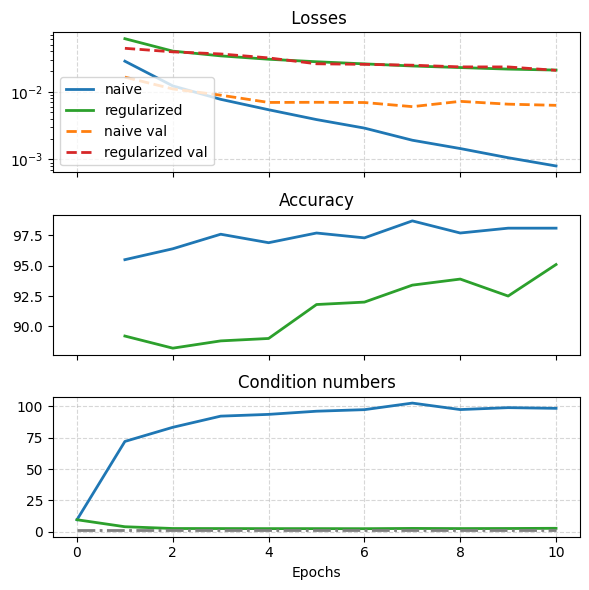

In [44]:
plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
Ts = np.arange(0, args.epochs+1)

ax = axes[0]
ax.plot(Ts[1:], fit, 'tab:blue', linewidth=2, label='naive')
ax.plot(Ts[1:], fit_reg, 'tab:green', linewidth=2, label='regularized')
ax.plot(Ts[1:], fit_val, 'tab:orange', linewidth=2, linestyle='--', label='naive val')
ax.plot(Ts[1:], fit_reg_val, 'tab:red', linewidth=2, linestyle='--', label='regularized val')

ax.set_yscale('log')
ax.set_title(' Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts[1:], acc, 'tab:blue', linewidth=2, label='naive')
ax.plot(Ts[1:], acc_reg, 'tab:green', linewidth=2, label='regularized')
ax.set_title('Accuracy')

ax = axes[2]
ax.plot(Ts, cond, 'tab:blue', linewidth=2)
ax.plot(Ts, cond_reg, 'tab:green', linewidth=2)
ax.plot(Ts, np.ones(len(Ts)), 'tab:gray', linewidth=2, label='Tightened', linestyle='-.')
#ax.set_yscale('log')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='lower left')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fit_MNIST.pdf', bbox_inches='tight')